In [1]:
from datetime import datetime
import math
from math import pi, sin, cos, sqrt

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Wedge
from matplotlib.patches import Arc, Ellipse, Polygon
import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

### Create ColorLists for Use.

Named colors are useful.

In [2]:
import matplotlib.colors as mcolors
colors_d = mcolors.CSS4_COLORS
# Sort colors by hue, saturation, value and name
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors_d.items())
mcolor_names = [name for hsv, name in by_hsv] #pluck the names, sorted by HSV



BLACK_WHITES = mcolor_names[:13]
RED_BROWNS = mcolor_names[14:29]
BROWNS = mcolor_names[29:36]
BEIGES = mcolor_names[36:49]
YELLOWS = mcolor_names[50:64]
GREENS = mcolor_names[64:81]
CYANS = mcolor_names[85: 99]
BLUES = mcolor_names[100:121]
PURPLES = mcolor_names[122:132]
PINKS = mcolor_names[132:145]

red_inds = [21, 22, 23, 24, 25, 26, 27, 145]
REDS = [mcolor_names[x] for x in red_inds]




In [3]:
REDS

['red',
 'mistyrose',
 'salmon',
 'tomato',
 'darksalmon',
 'coral',
 'orangered',
 'crimson']

In [5]:
PI = math.pi


def hex_corner(center, size, i, flat=True):
    '''Return the ith vertex of a regular hex with center of size i and flat/pointy orientation'''

    if flat:
        angle_rad = PI / 180 * (60*i)
    else:
        angle_rad = PI / 180 * (60*i-30)
        
    return Point(center.x + size * cos(angle_rad),
                 center.y + size * sin(angle_rad))

  

In [6]:


class Point():
    def __init__(self, x, y):
        '''Defines x and y variables'''
        self.x = x
        self.y = y
        
    def __str__(self):
        return "Point(%s,%s)"%(self.x,self.y)

class Hex():
    
    def __init__(self, x, y, size=1, flat=True, h=None, w=None, cube=None):
        '''Define center x and y variables'''
        self.x = x
        self.y = y
        self.center= Point(x, y)
        
        self.size = size
        self.flat = flat
        self.verts = None
        
        if self.flat:
            self.h = sqrt(3) * size
            self.w = 2 * size
        else:
            self.w = sqrt(3) * size
            self.h = 2 * size
            
        self.cube = cube # cube coords of this particular hex

    def __str__(self):
        desc = 'Flat' if self.flat else 'Pointy'
        return f" {desc}-Hex @ {(self.x,self.y)} size {self.size}"
    
        
    def get_verts(self):
        ''' Calculate all 6 verticles of the hex'''
        verts = []
        for v in range(6):
            verts.append(hex_corner(self.center, self.size, v, self.flat))
            
        self.verts = verts
        return self.verts


    def render(self, ax=None, **kwargs):
        """ Draws the edges of a given Hexagon. fc will color the face."""
                
        if ax is None:
            ax = plt.gca()
            
        if self.verts:
            vs = self.verts
        else:
            vs = self.get_verts()
                    

        rot_radians = pi/6 if self.flat else 0
        polygon = mpatches.RegularPolygon((self.x, self.y), 
                                         numVertices=6, radius=self.size,   
                                         orientation=rot_radians,
                                          **kwargs)
        ax.add_patch(polygon)
                    
        if 0:
            x_arr = [v.x for v in vs] + [vs[0].x]
            y_arr = [v.y for v in vs] + [vs[0].y]
            edge = Line2D([x_arr],[y_arr], **kwargs)
            ax.add_line(edge)
        return ax,

    
    def v_connect(self, v_pairs, ax=None, **kwargs):
        """ Draws edges from specific vertices to specified vertices..."""
                
        if ax is None:
            ax = plt.gca()
            
        
        if self.verts is None:
            self.verts = self.get_verts()

        #for each vp in v_pairs, connect vi to vj by drawing a Line2D
        for i, j in v_pairs:
            #print(i, j)
            #plot this line for this hexagon
            x_arr = [self.verts[i].x, self.verts[j].x]
            y_arr = [self.verts[i].y, self.verts[j].y]            
            edge = Line2D([x_arr],[y_arr], **kwargs)
            ax.add_line(edge)
        return ax,

    
    def render_spokes(self, vlist, ax=None, **kwargs):
        """ Draws spokes from center to specific vertices"""
                
        if ax is None:
            ax = plt.gca()
            
        if self.verts is None:
            self.verts = self.get_verts()

        #for each vp in v_pairs, connect vi to vj by drawing a Line2D
        for v in vlist:
            x_arr = [self.verts[v].x, self.x]
            y_arr = [self.verts[v].y, self.y]            
            edge = Line2D([x_arr],[y_arr], **kwargs)
            ax.add_line(edge)
        return ax,

    
    def render_polygon(self, pt_list, include_center, ax=None, **kwargs):
        """ Draw a Polygon to connect specific vertices and optionally center
        
        
        Parameters:
        
        include_center: Boolean
            Indicates whether the Center of the hexagon should to a vertex of the Polygon being rendered
        
        """
                
        if ax is None:
            ax = plt.gca()
            
        if self.verts is None:
            self.verts = self.get_verts()

        #Make a polygon of all the pts in pt_list
        xy_arr = []        
        if include_center:
            xy_arr.append([self.x, self.y])            
        
        for v in pt_list:
            if v in range(6):
                xy_arr.append([self.verts[v].x, self.verts[v].y])            
            
        polygon = Polygon(xy_arr,
                          closed=True,
                          **kwargs)            
        ax.add_patch(polygon)

        return ax,

    
class HexGrid():

    """Represents the dimensions of a hex grid as painted on the screen.
    The hex grid can be flat topped (flat = True) or pointy-topped (flat=False)
    
    It has a list of hexs in hlist
    And there is a rectangle (a bounding box) for the grid, since it has to be rendered in the xy plane
    
    """
    def __init__(self, num_rows, num_cols, size=1, flat=True, rect_h=None, rect_w=None):
        
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.size = size
        self.flat = flat
        self.hlist = []
        self.centers = []
        
        if flat:
            hexh = sqrt(3) * size
            hexw = 2 * size
            xdist = 3/2*hexw
            ydist = hexh/2
        else:
            hexw = sqrt(3) * size
            hexh = 2 * size
            ydist = 3/4*hexh
            xdist = hexw
        
        for row in range(num_rows):
            if flat:
                xoffset = (3/4*hexw if row%2 else 0) - ((num_cols+1)*size)
                yoffset = -1 * hexh * (num_rows // 4)
            else:
                xoffset = (0 if row%2 else hexw/2 ) - (num_cols//2 * hexw)       
                yoffset = -1 * (hexh * (num_rows // 2)) + (size*(num_rows//2-1))

            for col in range(num_cols):        
                c = Point(xoffset + col*xdist, ydist*row + yoffset)
                hx = Hex(c.x, c.y, size, flat=flat) #instantiate Hex based on center and size
                hx.get_verts()
                self.hlist.append(hx) 
                self.centers.append(c)
                
                
    def __str__(self):
        desc = 'Flat' if self.flat else 'Pointy'
        str1 = f" HexGrid: {desc}-hexagons {self.num_rows} by {self.num_cols} of size {self.size}\n"
        str2 = f'A total of {len(self.centers)} hexagons\n'
        
        return str1 + str2
    
    
    def render_grid(self, **kwargs):
        
        for h in self.hlist:
            h.render(**kwargs)
            
        plt.axis('on');    
        ax.axis('scaled')

        
    def render_grid_vconnect(self, v_pairs=None, **kwargs):
        """ For entire HexGrid connect vert to vert"""
        
        if v_pairs is not None:
            for h in self.hlist:
                h.v_connect(v_pairs, **kwargs)
                            
        plt.axis('on');    
        ax.axis('scaled')

        
    def render_grid_spokes(self, c_to_vlist=None, **kwargs):
        """ For entire HexGrid connect center to vlist"""
        
        # connect from hex center to each of the specified vertices
        if c_to_vlist is not None:
            for h in self.hlist:
                h.render_spokes(c_to_vlist, **kwargs)
            
        plt.axis('on');    
        ax.axis('scaled')

    def render_grid_polygons(self, pt_list=None, **kwargs):
        """ For entire HexGrid connect center to vlist"""
        
        # connect from hex center to each of the specified vertices
        if pt_list is not None:
            for h in self.hlist:
                h.render_polygon(pt_list, **kwargs)
            
        
        
    def render_grid_vertices(self, **kwargs):
        for h in self.hlist:
            for v in h.verts[:3]:
                plt.scatter(v.x, v.y, **kwargs)

                plt.scatter(h.x, h.y, **kwargs)

        #plt.axis('scaled')
        plt.axis('on');    
        ax.axis('scaled')




TypeError: render_polygon() missing 1 required positional argument: 'include_center'

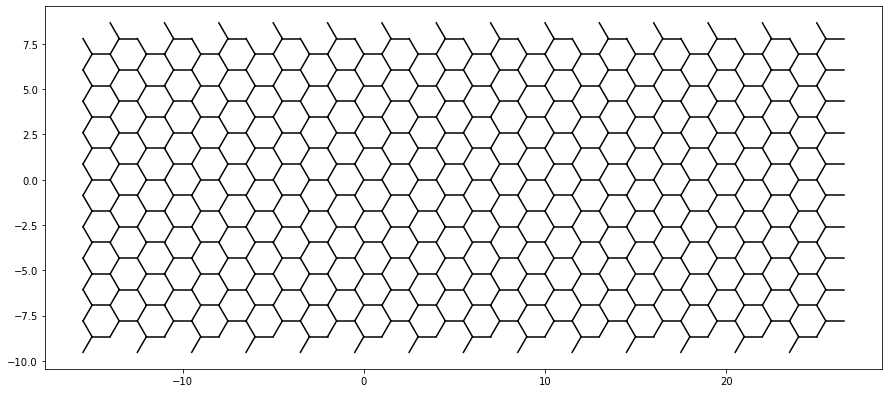

In [7]:
#h1 = Hex(2,1, 3, flat=True)
#print(h1)




fig, ax = plt.subplots(figsize=(15,15))


#h1.v_connect(v_pairs)
#h1.render(ax)

hg2 = HexGrid(20,14,1, flat=True)
v_pairs = [(1,3), (3,5), (5,1), (0,2), (2,4), (4,0)]
c_to_v = [1,3,5]
pt_list = [0,1, 2, 'c']
#hg2.render_grid_vertices(alpha=0.4, marker='.', color='k')
#hg2.render_grid_vconnect(v_pairs=v_pairs,
#                         alpha=0.4, marker='.', color='g')
#hg2.render_grid_spokes(c_to_v,
#                         alpha=0.4, marker='.', color='blue')

hg2.render_grid_spokes([2, 4, 0],                         
#                        alpha=0.4, 
                        color='k')


poly_lists = (([0,1, 2, 'c'], 'red'), \
              ([2,3, 4, 'c'], 'orange'), \
              ([4, 5, 0, 'c'], 'pink'))

for pt_list in poly_lists:
    hg2.render_grid_polygons(pt_list[0],                         
                           alpha=0.4, 
                           color=pt_list[1], 
                             fill=True)

hg2.render_grid(color='k', fill=None)

ax.axis('scaled')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
#hg2.hlist[10].render()#
#plt.axis('scaled')


```
BLACK_WHITES = mcolor_names[:13]
RED_BROWNS = mcolor_names[14:29]
BROWNS = mcolor_names[29:36]
BEIGES = mcolor_names[36:49]
YELLOWS = mcolor_names[50:64]
GREENS = mcolor_names[64:81]
CYANS = mcolor_names[85: 99]
BLUES = mcolor_names[100:121]
PURPLES = mcolor_names[122:132]
PINKS = mcolor_names[132:145]

red_inds = [21, 22, 23, 24, 25, 26, 27, 145]
REDS = [mcolor_names[x] for x in red_inds]
```





In [27]:
len(mcolor_names)


139

## TRIANGLES

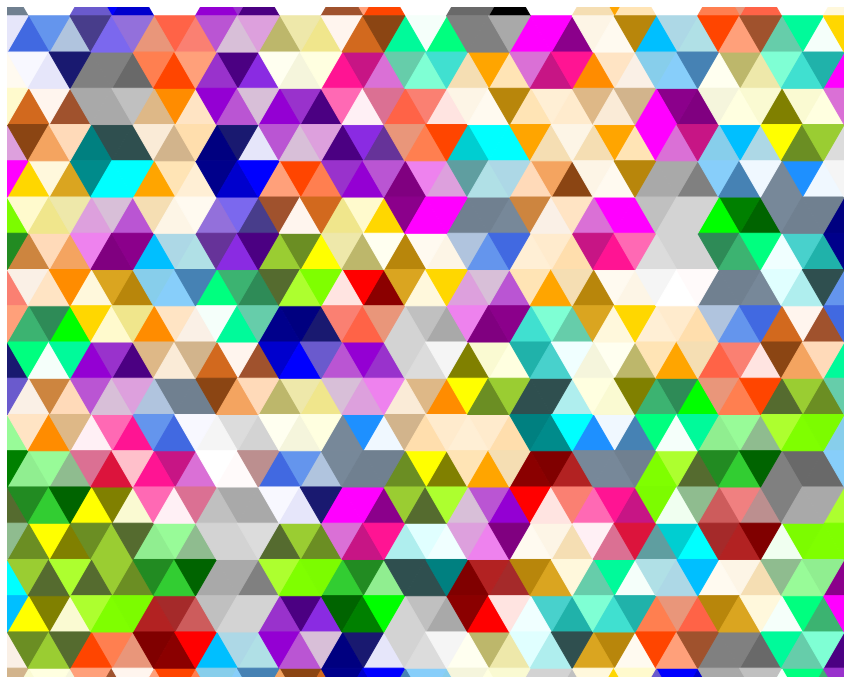

In [31]:
#Rhombuses are made up of 3 Adjacent vertices and the Center
RHOMBUSES1 = {'west': (0,1,2), 'northeast': (2,3,4), 'southwest': (4,5,0)}
RHOMBUSES2 = {'northwest': (1,2,3), 'east': (3,4,5),  'south':(5, 0,1)}
SPOKES_3A = (1,3,5)
SPOKES_3B = (0,2,4)
TRIANGLES = ((0,1), (1,2), (2,3), (3,4), (4,5), (5,0) )


color_sets = [REDS, PINKS, PURPLES, BLUES, CYANS, GREENS, YELLOWS, BEIGES, BROWNS, RED_BROWNS, BLACK_WHITES]

fig, ax = plt.subplots(figsize=(15,15))


hg = HexGrid(20,14,1, flat=True)


for h in hg.hlist:
#    palette = np.random.choice(color_sets)
    start = np.random.randint(0, 142)
    for idx, pt_list in enumerate(TRIANGLES):
        h.render_polygon(pt_list, include_center=True,
#                         alpha=round(np.random.random(), 1),
#                           color=np.random.choice(palette),
                         color = mcolor_names[start+idx],
                         fill=True)

OUTLINE = False
SPOKES = False
        
        
if OUTLINE:
    hg.render_grid(color='w', 
                   lw=4,
                   fill=None)
if SPOKES:        
    c_to_v = [1,3,5]
    hg.render_grid_spokes([0, 2,4],
                          color='k', lw=4)

ax.axis('scaled')
ax.set_xlim(-10, 10)
ax.set_ylim(-8, 8)
plt.axis('off')

SAVE_FILE = True


if SAVE_FILE:
    dtstr = datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%p")
    plt.savefig(f'../images/Triangles_{dtstr}.jpg')

### Cube Effect using 3 Rhombuses

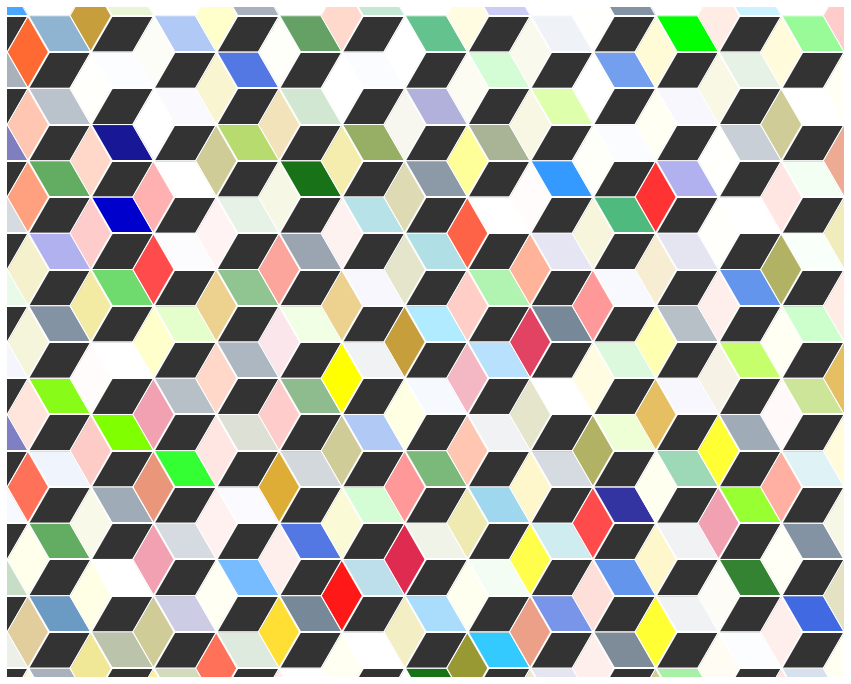

In [9]:
#Rhombuses are made up of 3 Adjacent vertices and the Center
RHOMBUSES1 = {'west': (0,1,2), 'northeast': (2,3,4), 'southwest': (4,5,0)}
RHOMBUSES2 = {'northwest': (1,2,3), 'east': (3,4,5),  'south':(5, 0,1)}
SPOKES_3A = (1,3,5)
SPOKES_3B = (0,2,4)

fig, ax = plt.subplots(figsize=(15,15))


hg = HexGrid(20,14,1, flat=True)


for pt_list in list(RHOMBUSES1.values())[0:1]:
    for h in hg.hlist:
        h.render_polygon(pt_list, include_center=True,
                         alpha=round(np.random.random(), 1),
                           color=np.random.choice(GREENS+BLUES), 
                         fill=True)


for pt_list in list(RHOMBUSES1.values())[1:2]:
    for h in hg.hlist:
        h.render_polygon(pt_list, include_center=True,
                           color=np.random.choice(REDS+YELLOWS), 
                         alpha=round(np.random.random(), 1),
                             fill=True)
        
        
for pt_list in list(RHOMBUSES1.values())[2:]:        
    for h in hg.hlist:
        h.render_polygon(pt_list, 
                         include_center=True,
                         alpha=0.8,
                         color='k', 
                         fill=True)

OUTLINE = True
SPOKES = True
        
        
if OUTLINE:
    hg.render_grid(color='w',
                   fill=None)
if SPOKES:        
    c_to_v = [1,3,5]
    hg.render_grid_spokes([0, 2,4],
                          color='w', lw=2)

ax.axis('scaled')
ax.set_xlim(-10, 10)
ax.set_ylim(-8, 8)
plt.axis('off')

SAVE_FILE = True


if SAVE_FILE:
    dtstr = datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%p")
    plt.savefig(f'../images/{dtstr}.jpg')

In [ ]:
BLUES + GREENS

In [ ]:
h1 = Hex(0,0, 3, flat=False)
vs = h1.get_verts()
for v in vs:
    plt.scatter(v.x, v.y, color='r')

plt.scatter(h1.x, h1.y, color='k')
    
plt.axis('scaled')




In [ ]:

def draw_hex_given_v(vs, ax):

    x_arr = [v.x for v in vs] + [vs[0].x]
    y_arr = [v.y for v in vs] + [vs[0].y]
    edge = Line2D([x_arr],[y_arr], **kwargs)
    ax.add_line(edge)
    return ax,


def draw_hex_given_c(c, size, flat=True, ax=None, **kwargs):
    
    if ax is None:
        ax = plt.gca()
        
    h1 = Hex(c.x,c.y, size, flat=flat)
        
    vs = h1.get_verts()
    ax = draw_hex_given_v(vs, ax)
    return ax,

In [ ]:

    
    
fig, ax = plt.subplots(figsize=(15,10))


num_rows = 10
num_cols = 5
size = 1
flat=False

render_grid(size, num_rows, num_cols, flat=flat, color='#F01212', fill=None)


In [ ]:
def HexagonRing(x,y,n,r):
    dc = n*math.sqrt(3) # distance between to neighbouring hexagon centers
    xc,yc = x,y-r*dc # hexagon center of one before first hexagon (=last hexagon)
    dx,dy = -dc*math.sqrt(3)/2,dc/2 # direction vector to next hexagon center
    for i in range(0,6):
        # draw r hexagons in line
        for j in range(0,r):
            xc,yc = xc+dx,yc+dy
            Hexagon(xc,yc,n)
        # rotate direction vector by 60°
        dx,dy = (math.cos(math.pi/3)*dx+math.sin(math.pi/3)*dy,
               -math.sin(math.pi/3)*dx+math.cos(math.pi/3)*dy)

In [ ]:
def tessellation(depth, pos):

    plt.scatter(*pos, color='r', marker='o') #stamp the current spot
    if depth:        
        angle = 0
        if depth==1:
            color = 'black' 
        else: 
            color = 'red'
        
        while angle < (2*pi):
            dx = round(2 * INNER_RADIUS * cos(angle), 10)
            dy = round(2 * INNER_RADIUS * sin(angle), 10)
            newx = pos[0]+dx
            newy = pos[1]+dy
            #draw a line from xy to x+dx, y+dy
            #print(f'line from {pos}, {(pos[0]+dx, pos[1]+dy)} {(newx, newy)} in {color}')
            
            l = Line2D([pos[0], newx], 
                       [(pos[1], newy)], color=color)
            ax.add_artist(l)

            pos = (pos[0]+dx, pos[1]+dy)

            tessellation(depth - 1, pos)

            angle += (2 * pi) / SIDES
            


In [ ]:
SIDES = 6
OUTER_RADIUS = 1
INNER_RADIUS = 0.5 #3**0.5 * OUTER_RADIUS / 2

fig, ax = plt.subplots(figsize=(15,10))



tessellation(3, (0,0))
plt.axis('scaled');
